# Day 10
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian,

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [195]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [3]:
class RotationReflectionBatch(BatchYielder):
    def __init__(self, header, datafile=None, inputPipe=None,
                 rotate=True, reflect=True, augRotMult=4,
                 trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.rotateAug = rotate
        self.reflectAug = reflect
        self.augmented = True
        self.augRotMult = augRotMult
        
        if self.rotateAug and not self.reflectAug:
            self.augMult = self.augRotMult
            
        elif not self.rotateAug and self.reflectAug:
            self.reflectAxes = ['_px', '_py', '_pz']
            self.augMult = 8
            
        elif not self.rotateAug and not self.reflectAug:
            self.augmented = False
            trainTimeAug = False
            testTimeAug = False
            self.augMult = 0
            print 'No augmentation specified!'
            inputPipe = None
            self.getTestBatch = self.getBatch
            
        else: #reflect and rotate
            self.reflectAxes = ['_px', '_pz']
            self.augMult = self.augRotMult*4
            
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        self.inputPipe = inputPipe
        
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    def rotate(self, inData, vectors):
        for vector in vectors:
            if 'jet_leading' in vector:
                cut = inData.PRI_jet_num >= 0.9
                inData.loc[cut, vector + '_px'] = inData.loc[cut, vector + '_px']*np.cos(inData.loc[cut, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[cut, 'aug_angle'])
                inData.loc[cut, vector + '_py'] = inData.loc[cut, vector + '_py']*np.cos(inData.loc[cut, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[cut, 'aug_angle'])
            elif 'jet_subleading' in vector:
                cut = inData.PRI_jet_num >= 1.9
                inData.loc[cut, vector + '_px'] = inData.loc[cut, vector + '_px']*np.cos(inData.loc[cut, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[cut, 'aug_angle'])
                inData.loc[cut, vector + '_py'] = inData.loc[cut, vector + '_py']*np.cos(inData.loc[cut, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[cut, 'aug_angle'])
            else:
                inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
                inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
    
    def reflect(self, inData, vectors):
        for vector in vectors:
            for coord in self.reflectAxes:
                try:
                    cut = (inData['aug' + coord] == 1)
                    if 'jet_leading' in vector:
                        cut = cut & (inData.PRI_jet_num >= 0.9)
                    elif 'jet_subleading' in vector:
                        cut = cut & (inData.PRI_jet_num >= 1.9)
                    inData.loc[cut, vector + coord] = -inData.loc[cut, vector + coord]
                except KeyError:
                    pass
            
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        if not self.augmented:
            return {'inputs':np.array(datafile['fold_' + index + '/inputs']),
                    'targets':targets,
                    'weights':weights}

        if isinstance(self.inputPipe, types.NoneType):
            inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        else:
            inputs = pandas.DataFrame(self.inputPipe.inverse_transform(np.array(datafile['fold_' + index + '/inputs'])), columns=self.header)            
        
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        if self.rotateAug:
            inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
            self.rotate(inputs, vectors)
            
        if self.reflectAug:
            for coord in self.reflectAxes:
                inputs['aug' + coord] = np.random.randint(0, 2, size=len(inputs))
            self.reflect(inputs, vectors)
            
        if isinstance(self.inputPipe, types.NoneType):
            inputs = inputs[self.header].values
        else:
            inputs = inputPipe.transform(inputs[self.header].values)
        
        return {'inputs':inputs,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        if isinstance(self.inputPipe, types.NoneType):
            inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        else:
            inputs = pandas.DataFrame(self.inputPipe.inverse_transform(np.array(datafile['fold_' + index + '/inputs'])), columns=self.header)            
            
        if self.reflectAug and self.rotateAug:
            rotIndex = augIndex%self.augRotMult
            refIndex = '{0:02b}'.format(int(augIndex/4))
            vectors = [x[:-3] for x in inputs.columns if '_px' in x]
            inputs['aug_angle'] = np.linspace(0, 2*np.pi, (self.augRotMult)+1)[rotIndex]
            for i, coord in enumerate(self.reflectAxes):
                inputs['aug' + coord] = int(refIndex[i])
            self.rotate(inputs, vectors)
            self.reflect(inputs, vectors)
            
        elif self.reflectAug:
            refIndex = '{0:03b}'.format(int(augIndex))
            vectors = [x[:-3] for x in inputs.columns if '_px' in x]
            for i, coord in enumerate(self.reflectAxes):
                inputs['aug' + coord] = int(refIndex[i])
            self.reflect(inputs, vectors)
            
        else:
            vectors = [x[:-3] for x in inputs.columns if '_px' in x]
            inputs['aug_angle'] = np.linspace(0, 2*np.pi, (self.augRotMult)+1)[augIndex]
            self.rotate(inputs, vectors)
            
        if isinstance(self.inputPipe, types.NoneType):
            inputs = inputs[self.header].values
        else:
            inputs = inputPipe.transform(inputs[self.header].values)

        return {'inputs':inputs,
                'targets':targets,
                'weights':weights}

## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [6]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.181s 


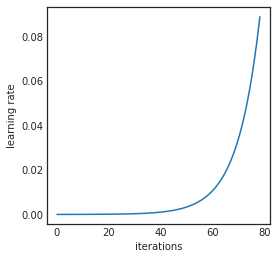

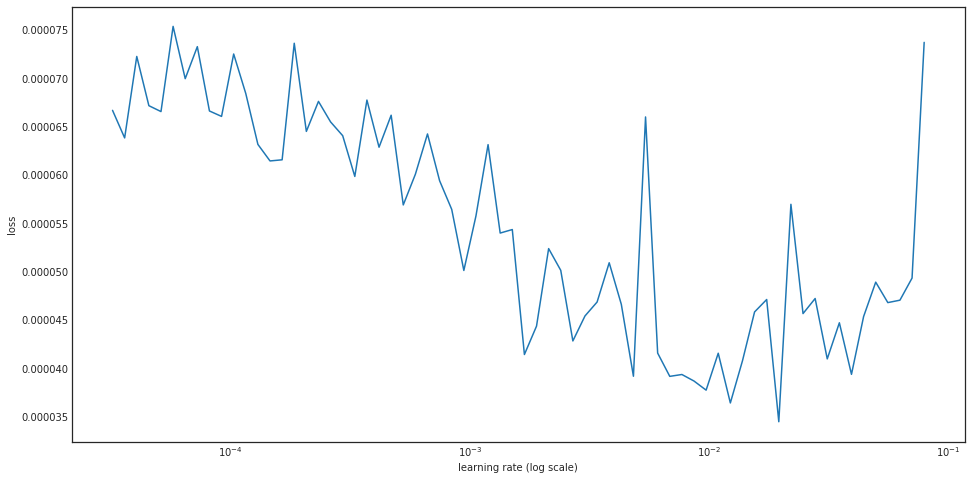

______________________________________



In [7]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [8]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.24574948219e-05
2 New best found: 3.78675681408e-05
3 New best found: 3.69165805748e-05
4 New best found: 3.67288045403e-05
5 New best found: 3.50440194986e-05
6 New best found: 3.48061173023e-05
7 New best found: 3.45982477617e-05
9 New best found: 3.41114023673e-05
10 New best found: 3.40726910951e-05
11 New best found: 3.39769901585e-05
12 New best found: 3.35987479466e-05
15 New best found: 3.34178529628e-05
19 New best found: 3.33548160289e-05
21 New best found: 3.32574457962e-05
22 New best found: 3.30857548645e-05
23 New best found: 3.30611007061e-05
24 New best found: 3.30139610629e-05
25 New best found: 3.2827289946e-05
28 New best found: 3.27189354471e-05
30 New best found: 3.26890618341e-05
42 New best found: 3.25960434683e-05
43 New best found: 3.25729594297e-05
44 New best found: 3.2269885227e-05
51 New best found: 3.20771008729e-05
54 New best fou

1 New best found: 4.38539886785e-05
2 New best found: 3.75306353046e-05
3 New best found: 3.68671216082e-05
4 New best found: 3.65383586746e-05
5 New best found: 3.57725320421e-05
6 New best found: 3.48800220938e-05
9 New best found: 3.47856377701e-05
10 New best found: 3.46402410866e-05
11 New best found: 3.42263892283e-05
12 New best found: 3.3939288333e-05
13 New best found: 3.38536275289e-05
15 New best found: 3.38423890673e-05
16 New best found: 3.38342999546e-05
18 New best found: 3.3830179574e-05
19 New best found: 3.35994079341e-05
23 New best found: 3.35585991888e-05
24 New best found: 3.3358081775e-05
26 New best found: 3.30658765616e-05
28 New best found: 3.30040891756e-05
29 New best found: 3.29984919507e-05
30 New best found: 3.29588386294e-05
41 New best found: 3.27530704288e-05
46 New best found: 3.26595199779e-05
48 New best found: 3.25306722824e-05
51 New best found: 3.24413778878e-05
53 New best found: 3.23184984802e-05
57 New best found: 3.2301032869e-05
61 New best 

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100292). Check your callbacks.
  % delta_t_median)


1 New best found: 4.18578619987e-05
2 New best found: 3.72292863319e-05
3 New best found: 3.62304949394e-05
5 New best found: 3.52558618968e-05
6 New best found: 3.42522986249e-05
9 New best found: 3.37317552878e-05
11 New best found: 3.33674908218e-05
12 New best found: 3.3254132586e-05
14 New best found: 3.31477288461e-05
15 New best found: 3.30720814234e-05
19 New best found: 3.26754976728e-05
21 New best found: 3.26064024569e-05
23 New best found: 3.24684760455e-05
25 New best found: 3.23955592183e-05
27 New best found: 3.21416202278e-05
30 New best found: 3.2092187906e-05
43 New best found: 3.20787440187e-05
45 New best found: 3.20590141925e-05
46 New best found: 3.1954002334e-05
50 New best found: 3.17382592576e-05
53 New best found: 3.17332637184e-05
54 New best found: 3.16116717511e-05
59 New best found: 3.14904903997e-05
83 New best found: 3.1475068124e-05
91 New best found: 3.14247653529e-05
97 New best found: 3.13426920773e-05
101 New best found: 3.13353293469e-05
108 New be

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128379). Check your callbacks.
  % delta_t_median)


1 New best found: 4.47930761421e-05
2 New best found: 3.99148253879e-05
3 New best found: 3.92244434288e-05
4 New best found: 3.74218771687e-05
5 New best found: 3.65779711279e-05
6 New best found: 3.648641788e-05
7 New best found: 3.64547649729e-05
8 New best found: 3.6309404558e-05
9 New best found: 3.61816522049e-05
10 New best found: 3.5639180485e-05
11 New best found: 3.5443719881e-05
12 New best found: 3.50601253676e-05
13 New best found: 3.49497488724e-05
14 New best found: 3.48914126149e-05
15 New best found: 3.48597753495e-05
17 New best found: 3.4730258896e-05
20 New best found: 3.45433724135e-05
21 New best found: 3.43546262985e-05
23 New best found: 3.41148165864e-05
25 New best found: 3.40133120393e-05
26 New best found: 3.3806196209e-05
29 New best found: 3.37823829326e-05
30 New best found: 3.3762663471e-05
39 New best found: 3.36355497321e-05
43 New best found: 3.33743013356e-05
48 New best found: 3.32033452769e-05
52 New best found: 3.30873109785e-05
53 New best found:

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188398). Check your callbacks.
  % delta_t_median)


1 New best found: 4.12874326476e-05
2 New best found: 3.65885004355e-05
3 New best found: 3.62965146416e-05
4 New best found: 3.50241709454e-05
5 New best found: 3.47932818771e-05
6 New best found: 3.42085509387e-05
7 New best found: 3.41198004489e-05
10 New best found: 3.37209632048e-05
11 New best found: 3.33762476341e-05
13 New best found: 3.31380528658e-05
14 New best found: 3.30501683387e-05
21 New best found: 3.27598829845e-05
23 New best found: 3.26666219083e-05
24 New best found: 3.237704801e-05
30 New best found: 3.2372746651e-05
31 New best found: 3.23361076759e-05
38 New best found: 3.22989805494e-05
43 New best found: 3.22628287897e-05
44 New best found: 3.22447904149e-05
45 New best found: 3.21679958741e-05
47 New best found: 3.2036140443e-05
50 New best found: 3.19788437482e-05
52 New best found: 3.19137288412e-05
58 New best found: 3.17668355042e-05
59 New best found: 3.17597328656e-05
62 New best found: 3.17350191841e-05
87 New best found: 3.1667037128e-05
99 New best f

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134212). Check your callbacks.
  % delta_t_median)


1 New best found: 4.34063634862e-05
2 New best found: 3.86412767593e-05
3 New best found: 3.80909779904e-05
4 New best found: 3.78543935791e-05
5 New best found: 3.71222824184e-05
6 New best found: 3.64626300035e-05
7 New best found: 3.63914482335e-05
8 New best found: 3.63337810776e-05
9 New best found: 3.59331345172e-05
11 New best found: 3.56968973699e-05
12 New best found: 3.54731491617e-05
13 New best found: 3.52191566874e-05
15 New best found: 3.52098923208e-05
19 New best found: 3.49608184525e-05
22 New best found: 3.48191085378e-05
23 New best found: 3.46909819732e-05
24 New best found: 3.43632442286e-05
26 New best found: 3.42608400787e-05
28 New best found: 3.42473165714e-05
30 New best found: 3.4190034207e-05
31 New best found: 3.41327143324e-05
38 New best found: 3.3963639946e-05
45 New best found: 3.39376063243e-05
48 New best found: 3.37467744918e-05
49 New best found: 3.36946871484e-05
51 New best found: 3.35380843575e-05
52 New best found: 3.35220466044e-05
55 New best 

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185574). Check your callbacks.
  % delta_t_median)


1 New best found: 4.42277832081e-05
2 New best found: 3.96417016269e-05
3 New best found: 3.89692155333e-05
4 New best found: 3.79375384642e-05
5 New best found: 3.76428027064e-05
6 New best found: 3.72976285503e-05
7 New best found: 3.68697700954e-05
9 New best found: 3.66776013382e-05
10 New best found: 3.61402271758e-05
11 New best found: 3.61303208309e-05
12 New best found: 3.59195816319e-05
13 New best found: 3.57113193126e-05
14 New best found: 3.56725677931e-05
15 New best found: 3.56588951017e-05
19 New best found: 3.55516144667e-05
20 New best found: 3.54871501327e-05
22 New best found: 3.50228945632e-05
23 New best found: 3.49433353356e-05
24 New best found: 3.48965373129e-05
25 New best found: 3.48168371487e-05
26 New best found: 3.47719902692e-05
27 New best found: 3.46357213336e-05
30 New best found: 3.45703377269e-05
41 New best found: 3.44925185699e-05
42 New best found: 3.43686776758e-05
47 New best found: 3.4268432523e-05
48 New best found: 3.3985150093e-05
53 New best

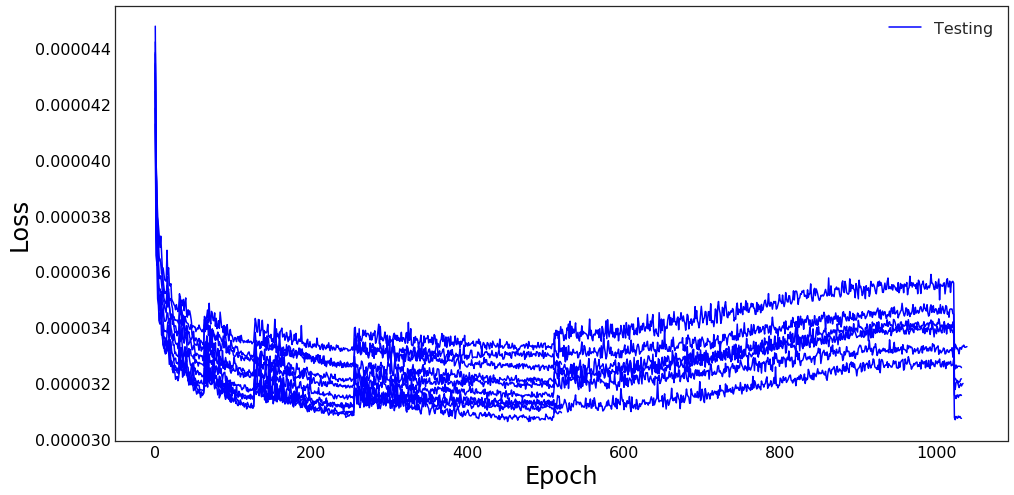

Mean loss = 3.17e-05 +- 2e-07
Mean AUC = 0.0984 +- 0.0009
Mean wAUC = 0.0635 +- 0.001
______________________________________



In [9]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, reduxDecay=True, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [196]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [197]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.063025015785535e-05
Model 1 is 5 with loss = 3.0865548992241726e-05
Model 2 is 7 with loss = 3.104687506827571e-05
Model 3 is 0 with loss = 3.1054273394334784e-05
Model 4 is 4 with loss = 3.14195745661631e-05
Model 5 is 2 with loss = 3.1778469930613926e-05
Model 6 is 6 with loss = 3.1962396487919885e-05
Model 7 is 8 with loss = 3.2455080995326304e-05
Model 8 is 3 with loss = 3.257726454186965e-05
Model 9 is 9 with loss = 3.3056065505063494e-05


## Response on val data

In [12]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [67]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [68]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [69]:
tPred = np.concatenate(pred, axis=1)

In [70]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [71]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [72]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [19]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5153221125943123

In [20]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5098565761367104

In [21]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.51174

### Ref

In [73]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5248403946604759

In [74]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5193774794018919

In [75]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.52126

### RotRef 4

In [37]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5248403946604759

In [38]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5150137320720171

In [39]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.5184

### RotRef 8

In [46]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5278003482298317

In [47]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5165395178516936

In [48]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.52042

### RotRef 10

In [55]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5283807312826465

In [56]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.5166310649984742

In [57]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.52068

### RotRef 16

In [64]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

0.5290771909460243

In [65]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

0.51547146780592

In [66]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

0.52016

In [89]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [203]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [204]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [205]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.903825016546, weighted 0.936022762662


In [206]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.902063907007075 0.96151376


(3.902063907007075, 0.96151376)

## Response on validation data Rot-Ref 4

In [207]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [208]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [209]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [210]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904048121318, weighted 0.936117806882


In [98]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.9354516298108813 0.9562446


(3.9354516298108813, 0.9562446)

## Response on validation data Rot-Ref 8

In [211]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [212]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [213]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [214]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904064613618, weighted 0.936127397042


In [215]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.946667721229724 0.9632657


(3.946667721229724, 0.9632657)

## Response on validation data Ref

In [216]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [217]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [218]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [219]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904080675547, weighted 0.936144198749


In [220]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.9185693606729024 0.96182704


(3.9185693606729024, 0.96182704)

## Response on validation data Rot 4

In [221]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [222]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [223]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [224]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904009176145, weighted 0.936076130721


In [225]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.935093899227462 0.9581222


(3.935093899227462, 0.9581222)

## Response on validation data Rot 5

In [226]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [227]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [228]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [229]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904033428434, weighted 0.936089420355


In [230]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.930939499116286 0.9663005


(3.930939499116286, 0.9663005)

## Response on validation data Rot 6

In [231]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [232]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [233]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [234]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904034500824, weighted 0.936088319023


In [235]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.926759655082747 0.9662959


(3.926759655082747, 0.9662959)

## Response on validation data Rot 8

In [236]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [237]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [238]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [239]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904032217015, weighted 0.936087016071


In [240]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.928069939459488 0.95791966


(3.928069939459488, 0.95791966)

## Response on validation data Rot 10

In [241]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [242]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [243]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [244]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904032576545, weighted 0.936087286253


In [245]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.9283522553419745 0.9579162


(3.9283522553419745, 0.9579162)

## Response on validation data Rot 16

In [246]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [247]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [248]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [249]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904032557063, weighted 0.936087233394


In [250]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.9283522553419745 0.95791584


(3.9283522553419745, 0.95791584)

## Response on validation data Rot-Ref 16

In [251]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [252]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [253]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [254]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904067742232, weighted 0.936129939119


In [255]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.930312481518534 0.96295744


(3.930312481518534, 0.96295744)

## Response on validation data Rot-Ref 3

In [256]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [257]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [258]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [259]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.90400732448, weighted 0.936121299076


In [260]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.9438997099821904 0.96288526


(3.9438997099821904, 0.96288526)

## Response on validation data Rot-Ref 5

In [261]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [262]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [263]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [264]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904076230135, weighted 0.936131261371


In [265]:
amsScanQuick(convertToDF(valData.source))

50000 candidates loaded
3.940036692183632 0.9629896


(3.940036692183632, 0.9629896)

# Final run

In [274]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.0041929043293s per sample

Predicting batch 2 out of 10
Prediction took 0.00398194111044s per sample

Predicting batch 3 out of 10
Prediction took 0.00390727887587s per sample

Predicting batch 4 out of 10
Prediction took 0.00391101232442s per sample

Predicting batch 5 out of 10
Prediction took 0.0036883030718s per sample

Predicting batch 6 out of 10
Prediction took 0.003820555817s per sample

Predicting batch 7 out of 10
Prediction took 0.0041084741289s per sample

Predicting batch 8 out of 10
Prediction took 0.00364367843541s per sample

Predicting batch 9 out of 10
Prediction took 0.00385060307329s per sample

Predicting batch 10 out of 10
Prediction took 0.00443902545409s per sample



In [275]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

../Data/Day_10_basic_rotref8_5_test.csv


In [276]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

Successfully submitted to Higgs Boson Machine Learning Challenge

## Response on validation data Rot-Ref 8 10

In [277]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [278]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [279]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [280]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904336393878, weighted 0.93622120754


In [281]:
cut = amsScanQuick(convertToDF(valData.source))[1]

50000 candidates loaded
3.9347726168373547 0.95998764


In [289]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

50000 candidates loaded


In [298]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

4.97196749855 5.01473909063


In [299]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [300]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

3.9074220622379157 0.95998764


(3.9074220622379157, 0.95998764)

In [328]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [336]:
amsScanQuick(convertToDF(valData.source), 1, 1)

50000 candidates loaded
1.7448610687361392 0.95998764


(1.7448610687361392, 0.95998764)

In [329]:
bests = foldAMSScan(convertToDF(valData.source))

50000 candidates loaded
[0.9753281474113464, 1.345941920072834]
Fold 0, best AMS 1.34594192007 at cut of 0.975328147411. Total weights Signal:Bkg. 13.7167768478:8151.65917969


/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[0.9858377575874329, 1.3867985250387396]
Fold 1, best AMS 1.38679852504 at cut of 0.985837757587. Total weights Signal:Bkg. 13.7795658112:8172.04101562
[0.983581006526947, 1.4414358597371966]
Fold 2, best AMS 1.44143585974 at cut of 0.983581006527. Total weights Signal:Bkg. 13.8481006622:8319.9375
[0.9404186606407166, 1.2485394644899082]
Fold 3, best AMS 1.24853946449 at cut of 0.940418660641. Total weights Signal:Bkg. 13.6938896179:8190.86474609
[0.9427838921546936, 1.2266774965448515]
Fold 4, best AMS 1.22667749654 at cut of 0.942783892155. Total weights Signal:Bkg. 13.7885246277:8086.55126953
[0.9770797491073608, 2.4728650219419634]
Fold 5, best AMS 2.47286502194 at cut of 0.977079749107. Total weights Signal:Bkg. 13.9748182297:8270.1484375
[0.9754099249839783, 1.3927320244095838]
Fold 6, best AMS 1.39273202441 at cut of 0.975409924984. Total weights Signal:Bkg. 14.3369216919:8249.79101562
[0.9606456160545349, 1.5890744111058275]
Fold 7, best AMS 1.58907441111 at cut of 0.9606456160

In [337]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

0.9638784468173981
0.9626363224736257
0.9653914582960732
0.9557010754710975
0.9646777562398445


In [282]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.0102225558194s per sample

Predicting batch 2 out of 10
Prediction took 0.00714328707348s per sample

Predicting batch 3 out of 10
Prediction took 0.00715095481439s per sample

Predicting batch 4 out of 10
Prediction took 0.00716434243809s per sample

Predicting batch 5 out of 10
Prediction took 0.00717327899933s per sample

Predicting batch 6 out of 10
Prediction took 0.00717131827094s per sample

Predicting batch 7 out of 10
Prediction took 0.00718027054613s per sample

Predicting batch 8 out of 10
Prediction took 0.00717530889078s per sample

Predicting batch 9 out of 10
Prediction took 0.00717386498018s per sample

Predicting batch 10 out of 10
Prediction took 0.00718395217982s per sample



In [338]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

../Data/Day_10_M_rotref8_10_test.csv


In [339]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

Successfully submitted to Higgs Boson Machine Learning Challenge

## Response on validation data Rot-Ref 16 10

In [340]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [341]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [343]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.0189333316326s per sample

Predicting batch 2 out of 10
Prediction took 0.01705866642s per sample

Predicting batch 3 out of 10
Prediction took 0.01929036479s per sample

Predicting batch 4 out of 10
Prediction took 0.0175134486198s per sample

Predicting batch 5 out of 10
Prediction took 0.0175624599934s per sample

Predicting batch 6 out of 10
Prediction took 0.0177510950089s per sample

Predicting batch 7 out of 10
Prediction took 0.0179121144295s per sample

Predicting batch 8 out of 10
Prediction took 0.0185949529648s per sample

Predicting batch 9 out of 10
Prediction took 0.0175262567997s per sample

Predicting batch 10 out of 10
Prediction took 0.0175568314075s per sample



In [344]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.904339597763, weighted 0.936222626452


In [345]:
amsScanQuick(convertToDF(valData.source), 1, 1)

50000 candidates loaded
1.7472080023156094 0.9634347


(1.7472080023156094, 0.9634347)

In [346]:
bests = foldAMSScan(convertToDF(valData.source))

50000 candidates loaded
[0.9806860089302063, 1.359051084446112]
Fold 0, best AMS 1.35905108445 at cut of 0.98068600893. Total weights Signal:Bkg. 13.9064006805:8144.05859375


/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[0.9367119073867798, 1.2363223089068271]
Fold 1, best AMS 1.23632230891 at cut of 0.936711907387. Total weights Signal:Bkg. 14.0525436401:8285.08886719
[0.9592130184173584, 1.6155390593049694]
Fold 2, best AMS 1.6155390593 at cut of 0.959213018417. Total weights Signal:Bkg. 13.9644622803:8361.75390625
[0.9806404709815979, 1.5845495619242753]
Fold 3, best AMS 1.58454956192 at cut of 0.980640470982. Total weights Signal:Bkg. 14.2921676636:8063.52441406
[0.9770373106002808, 1.3291674622215222]
Fold 4, best AMS 1.32916746222 at cut of 0.9770373106. Total weights Signal:Bkg. 13.9828681946:8023.92675781
[0.9512416124343872, 1.1706405601160217]
Fold 5, best AMS 1.17064056012 at cut of 0.951241612434. Total weights Signal:Bkg. 13.8208732605:8024.08154297
[0.9518672227859497, 1.5515321038875243]
Fold 6, best AMS 1.55153210389 at cut of 0.951867222786. Total weights Signal:Bkg. 14.6555528641:8286.48828125
[0.978404700756073, 1.351576983787843]
Fold 7, best AMS 1.35157698379 at cut of 0.978404700

In [350]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

Mean 0.9623899102210999
Inverse-AMS-weighted mean 0.9618595264700661
AMS-weighted mean 0.9628669633605695
AMS-Difference-weighted mean 0.9604763152422247
Inverse AMS-Difference-weighted mean 0.9637883888059864


In [348]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.0169123962576s per sample

Predicting batch 2 out of 10
Prediction took 0.0167690309308s per sample

Predicting batch 3 out of 10
Prediction took 0.0168373967431s per sample

Predicting batch 4 out of 10
Prediction took 0.0168076757821s per sample

Predicting batch 5 out of 10
Prediction took 0.0142331053821s per sample

Predicting batch 6 out of 10
Prediction took 0.014805176891s per sample

Predicting batch 7 out of 10
Prediction took 0.0708010923819s per sample

Predicting batch 8 out of 10
Prediction took 0.0146434947837s per sample

Predicting batch 9 out of 10
Prediction took 0.0145613361445s per sample

Predicting batch 10 out of 10
Prediction took 0.0145477535291s per sample



In [356]:
saveTest(0.95, 'Day_10_95_rotref16_10')

../Data/Day_10_95_rotref16_10_test.csv


In [358]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"

Successfully submitted to Higgs Boson Machine Learning Challenge